# Potential Energy Budget

Define primes as deviation from area mean:

$$\begin{eqnarray*}
\mathbf{u} &=& \langle \mathbf{u} \rangle + \mathbf{u}^{\prime} \\
w &=& \langle w \rangle + w^{\prime} \\
b &=& \langle b \rangle(t) + b^{\prime}(\mathbf{X},t) \\
&=& \langle \overline{b} \rangle + \langle b^* \rangle (t) + b^{\prime} (\mathbf{X}, t) \\
&=& \langle \overline{b} \rangle + \tilde{b} (\mathbf{X}, t) 
\end{eqnarray*}$$


and defining time mean stratification $N^2$ as
$$N^2 = \partial_z \langle \overline{b} \rangle$$

Start out with the buoyancy equation for $\tilde{b}$:

$$ \tilde{b}_t = \mathbf{u} \cdot \nabla \tilde{b} + wN^2  = Q$$

Multiplying by $\tilde{b}/N^2$ we get:

$$\partial_t \frac{\tilde{b}}{2N^2} + \frac{\mathbf{u} \tilde{b} \cdot \nabla \tilde{b}}{N^2} + w\tilde{b} = \frac{\tilde{b} Q}{N^2}  $$

Now, the different terms of the horizontal advection can be written as:

$$\mathbf{u} \tilde{b} \cdot \nabla \tilde{b} = \langle \mathbf{u}\rangle \langle b^* \rangle \cdot \nabla \tilde{b} + \mathbf{u}^{\prime} b^{\prime} \cdot \nabla \tilde{b} + \langle \mathbf{u}\rangle b^{\prime} \cdot \nabla \tilde{b} + \mathbf{u}^{\prime} \langle b^* \rangle \cdot \nabla \tilde{b}$$

We can also write $\cdot \nabla \tilde{b} = \cdot \nabla b$.

Taking area average $\langle ... \rangle$:

$$ \langle \mathbf{u} \tilde{b} \cdot \nabla \tilde{b} \rangle = \langle \mathbf{u}\rangle \langle b^* \rangle \cdot \langle \nabla \tilde{b} \rangle + \langle \mathbf{u}^{\prime} b^{\prime} \rangle \cdot \langle \nabla \tilde{b} \rangle + \langle \langle \mathbf{u}\rangle b^{\prime} \cdot \nabla \tilde{b} \rangle + \langle \mathbf{u}^{\prime} \langle b^* \rangle \cdot \nabla \tilde{b} \rangle$$

The last 2 terms (cross terms) vanish upon area integral leaving:

$$\frac{\mathbf{u} \tilde{b} \cdot \nabla \tilde{b}}{N^2} = \frac{\langle \mathbf{u}\rangle \langle b^* \rangle \cdot \langle \nabla b \rangle + \langle \mathbf{u}^{\prime} b^{\prime} \rangle \cdot \langle \nabla b \rangle}{N^2}$$

Similarly after area averaging the vertical term can be written as:

$$\langle w \tilde{b}\rangle = \langle w \rangle \langle b^* \rangle + \langle w^{\prime} b^{\prime} \rangle$$

So the APE equation can now be written as:

$$\partial_t \frac{\langle b^* \rangle}{2N^2} + \frac{\langle \mathbf{u}\rangle \langle b^* \rangle \cdot \langle \nabla b \rangle}{N^2} + \frac{\langle \mathbf{u}^{\prime} b^{\prime} \rangle \cdot \langle \nabla b \rangle}{N^2} + \langle w \rangle \langle b^* \rangle + \langle w^{\prime} b^{\prime} \rangle = \langle \frac{\tilde{b} Q}{N^2} \rangle $$

Taking time mean $(\overline{\cdot})$:

we get 

$$ \overline{\frac{\langle \mathbf{u}^{\prime} b^{\prime} \rangle \cdot \langle \nabla b \rangle}{N^2}} + \overline{\langle w^{\prime} b^{\prime} \rangle} = \overline{\langle \frac{\tilde{b} Q}{N^2} \rangle}$$

since $\overline{\langle b^*\rangle} = 0$
which for constant $Q$ gives us the APE balance we need

$$ \overline{\frac{\langle \mathbf{u}^{\prime} b^{\prime} \rangle \cdot \langle \nabla b \rangle}{N^2}} =- \overline{\langle w^{\prime} b^{\prime} \rangle} $$



In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm
import seaborn as sns
import cmocean
import sys
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit
from oceanmodes import baroclinic

from IPython import display
import time
from matplotlib.colors import LogNorm
from dask.distributed import Client, LocalCluster

from IPython.display import clear_output
import xgcm
import xrft

from dask.array import ones_like
from dask.diagnostics import ProgressBar

import gsw

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import jmd95

In [3]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color4, color3]
plt.rcParams.update({'figure.figsize' : (15,5)})


In [4]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

In [5]:
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


dirroot_s = '/central/groups/oceanphysics/anirban/smalldomain_4h/'
dirroot_n = '/central/groups/oceanphysics/anirban/smalldomain_NGS/'


res = ['2km','4km','8km','16km']
res2 = ['2km','4km','8km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]

xs1_n = [560,280,140]
xs2_n =[800,400,200]
ys1_n = [600,300,150]
ys2_n = [760,380,190]


zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])
zlevels = (zlevels -1).astype(int)


grids = {}
grids2 = {}
grids3 = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)


    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])
for it, r in enumerate(res2):
    grids3[r] = grids[r].isel(XC=slice(xs1_n[it], xs2_n[it]),
                              XG=slice(xs1_n[it], xs2_n[it]),
                              YC=slice(ys1_n[it], ys2_n[it]),
                              YG=slice(ys1_n[it], ys2_n[it]),
                              Z = zlevels, 
                              Zl = zlevels, 
                              Zu = zlevels, 
                              Zp1 = zlevels,).drop(['Zp1']).sel(XC=slice(-65, -61),
                                                                XG=slice(-65, -61),
                                                                YC=slice(39,42),
                                                                YG=slice(39,42))


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_8km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/grou

In [6]:
%%time
cross_spec = {}
KE_spec = {}
iso_spec = {}
timeseries = {}
for r in res:
    
    cross_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_crossspectra_*.nc' %r)
    KE_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_KEspectra_*.nc' %r)
    timeseries[r] = xr.open_dataset(dirroot_s+'timeseries/'+'%s_timeseries.nc' %r)
    iso_spec[r] = xr.merge([KE_spec[r], cross_spec[r]])
    print(r)

2km
4km
8km
16km
CPU times: user 1min 30s, sys: 3.73 s, total: 1min 33s
Wall time: 3min 24s


In [7]:
# Decorrelation time (days), 2km: (1 -> 0) = 43.58 ; (e-folding) = 12.58
# Decorrelation time (days), 4km: (1 -> 0) = 43.58 ; (e-folding) = 13.25
# Decorrelation time (days), 8km: (1 -> 0) = 42.83 ; (e-folding) = 14.33
# Decorrelation time (days), 16km: (1 -> 0) = 48.00 ; (e-folding) = 17.17

In [8]:
T_decor = {'2km': 43.58, '4km': 43.58 , '8km': 42.83, '16km': 48.00}
T_decor_e = {'2km': 12.58, '4km': 13.25, '8km': 14.33, '16km': 17.17}
for r in res:
    
    print('Decorrelation time (days), %s: (1 -> 0) = %3.2f ; (e-folding) = %3.2f' %(r,T_decor[r],T_decor_e[r]))

Decorrelation time (days), 2km: (1 -> 0) = 43.58 ; (e-folding) = 12.58
Decorrelation time (days), 4km: (1 -> 0) = 43.58 ; (e-folding) = 13.25
Decorrelation time (days), 8km: (1 -> 0) = 42.83 ; (e-folding) = 14.33
Decorrelation time (days), 16km: (1 -> 0) = 48.00 ; (e-folding) = 17.17


In [9]:
N_deg = {}
N_deg_e = {}
for r in res:
    N_deg[r] = int(round((len(timeseries[r].time)/6) / T_decor[r]))
    N_deg_e[r] = int(round((len(timeseries[r].time)/6) / T_decor_e[r]))
    print('N (degrees of freedom), %s: = %s, %s (e-folding) ' %(r,N_deg[r],N_deg_e[r]))


N (degrees of freedom), 2km: = 17, 58 (e-folding) 
N (degrees of freedom), 4km: = 17, 55 (e-folding) 
N (degrees of freedom), 8km: = 17, 51 (e-folding) 
N (degrees of freedom), 16km: = 15, 43 (e-folding) 


In [10]:
X_tot = {}
Y_tot = {}
Ndeg_s = {}
X_peak = (3.5e-6)**-1
Y_peak = (3.5e-6)**-1

for r in res:
    X_tot[r] = grids2[r].dxC.sum(dim='XG').mean(dim='YC').values
    Y_tot[r] = grids2[r].dyC.sum(dim='YG').mean(dim='XC').values
    Ndeg_s[r] = int(round(X_tot[r]*Y_tot[r]/(X_peak*Y_peak)))
    print('N(X) (degrees of freedom, spatial), %s: = %s' %(r,Ndeg_s[r]))

N(X) (degrees of freedom, spatial), 2km: = 10
N(X) (degrees of freedom, spatial), 4km: = 10
N(X) (degrees of freedom, spatial), 8km: = 10
N(X) (degrees of freedom, spatial), 16km: = 10


In [11]:
%%time
sq_timeseries = {}
for r in res:
    sq_timeseries[r] = xr.open_dataset(dirroot_s+'%s_sq_timeseries.nc' %r)
    print(r)

2km
4km
8km
16km
CPU times: user 102 ms, sys: 8.91 ms, total: 110 ms
Wall time: 328 ms


In [12]:
def calc_mean_std_from_timeseries(ts, sq_ts):
    varlist = ['wpbp','Upbp_gradb','gradb','b_z','b_x','b_y','bvar','wp2']
    
    mstd = xr.merge([xr.merge([np.sqrt(sq_ts[v].mean(dim='time') - (ts[v].mean(dim='time')**2)).to_dataset(name=v+'_s') for v in varlist]) , 
                         xr.merge([ts[v].mean(dim='time').to_dataset(name=v+'_m') for v in varlist])])
    return mstd

In [13]:
mean_std = {}
for r in res:
    mean_std[r] = calc_mean_std_from_timeseries(timeseries[r], sq_timeseries[r])

In [14]:
mean_std['2km']

<xarray.Dataset>
Dimensions:       (Z: 56)
Coordinates:
  * Z             (Z) float32 -7.5 -12.5 -17.5 ... -885.465 -933.755 -982.51
    drF           (Z) float32 5.0 5.0 5.0 5.0 5.0 ... 47.38 48.03 48.55 48.96
    PHrefC        (Z) float32 73.575 122.625 171.675 ... 9160.137 9638.423
Data variables:
    wpbp_s        (Z) float64 1.423e-07 2.358e-07 ... 3.929e-07 3.953e-07
    Upbp_gradb_s  (Z) float64 2.138e-12 2.12e-12 2.147e-12 ... 1.822e-14 1.7e-14
    gradb_s       (Z) float64 5.513e-08 6.269e-08 ... 7.647e-09 7.502e-09
    b_z_s         (Z) float64 6.785e-05 0.0001038 ... 1.796e-06 1.712e-06
    b_x_s         (Z) float64 4.924e-08 5.587e-08 ... 9.442e-09 9.629e-09
    b_y_s         (Z) float64 5.083e-08 5.734e-08 ... 9.546e-09 9.725e-09
    bvar_s        (Z) float64 4.715e-06 4.862e-06 ... 4.013e-07 3.402e-07
    wp2_s         (Z) float32 1.573426e-08 4.218361e-08 ... 1.2408472e-06
    wpbp_m        (Z) float64 4.372e-09 6.78e-09 ... -2.772e-10 -3.59e-10
    Upbp_gradb_m  (Z) flo

In [15]:
labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}

In [44]:
figdir = 'figs_paper_Oct/'

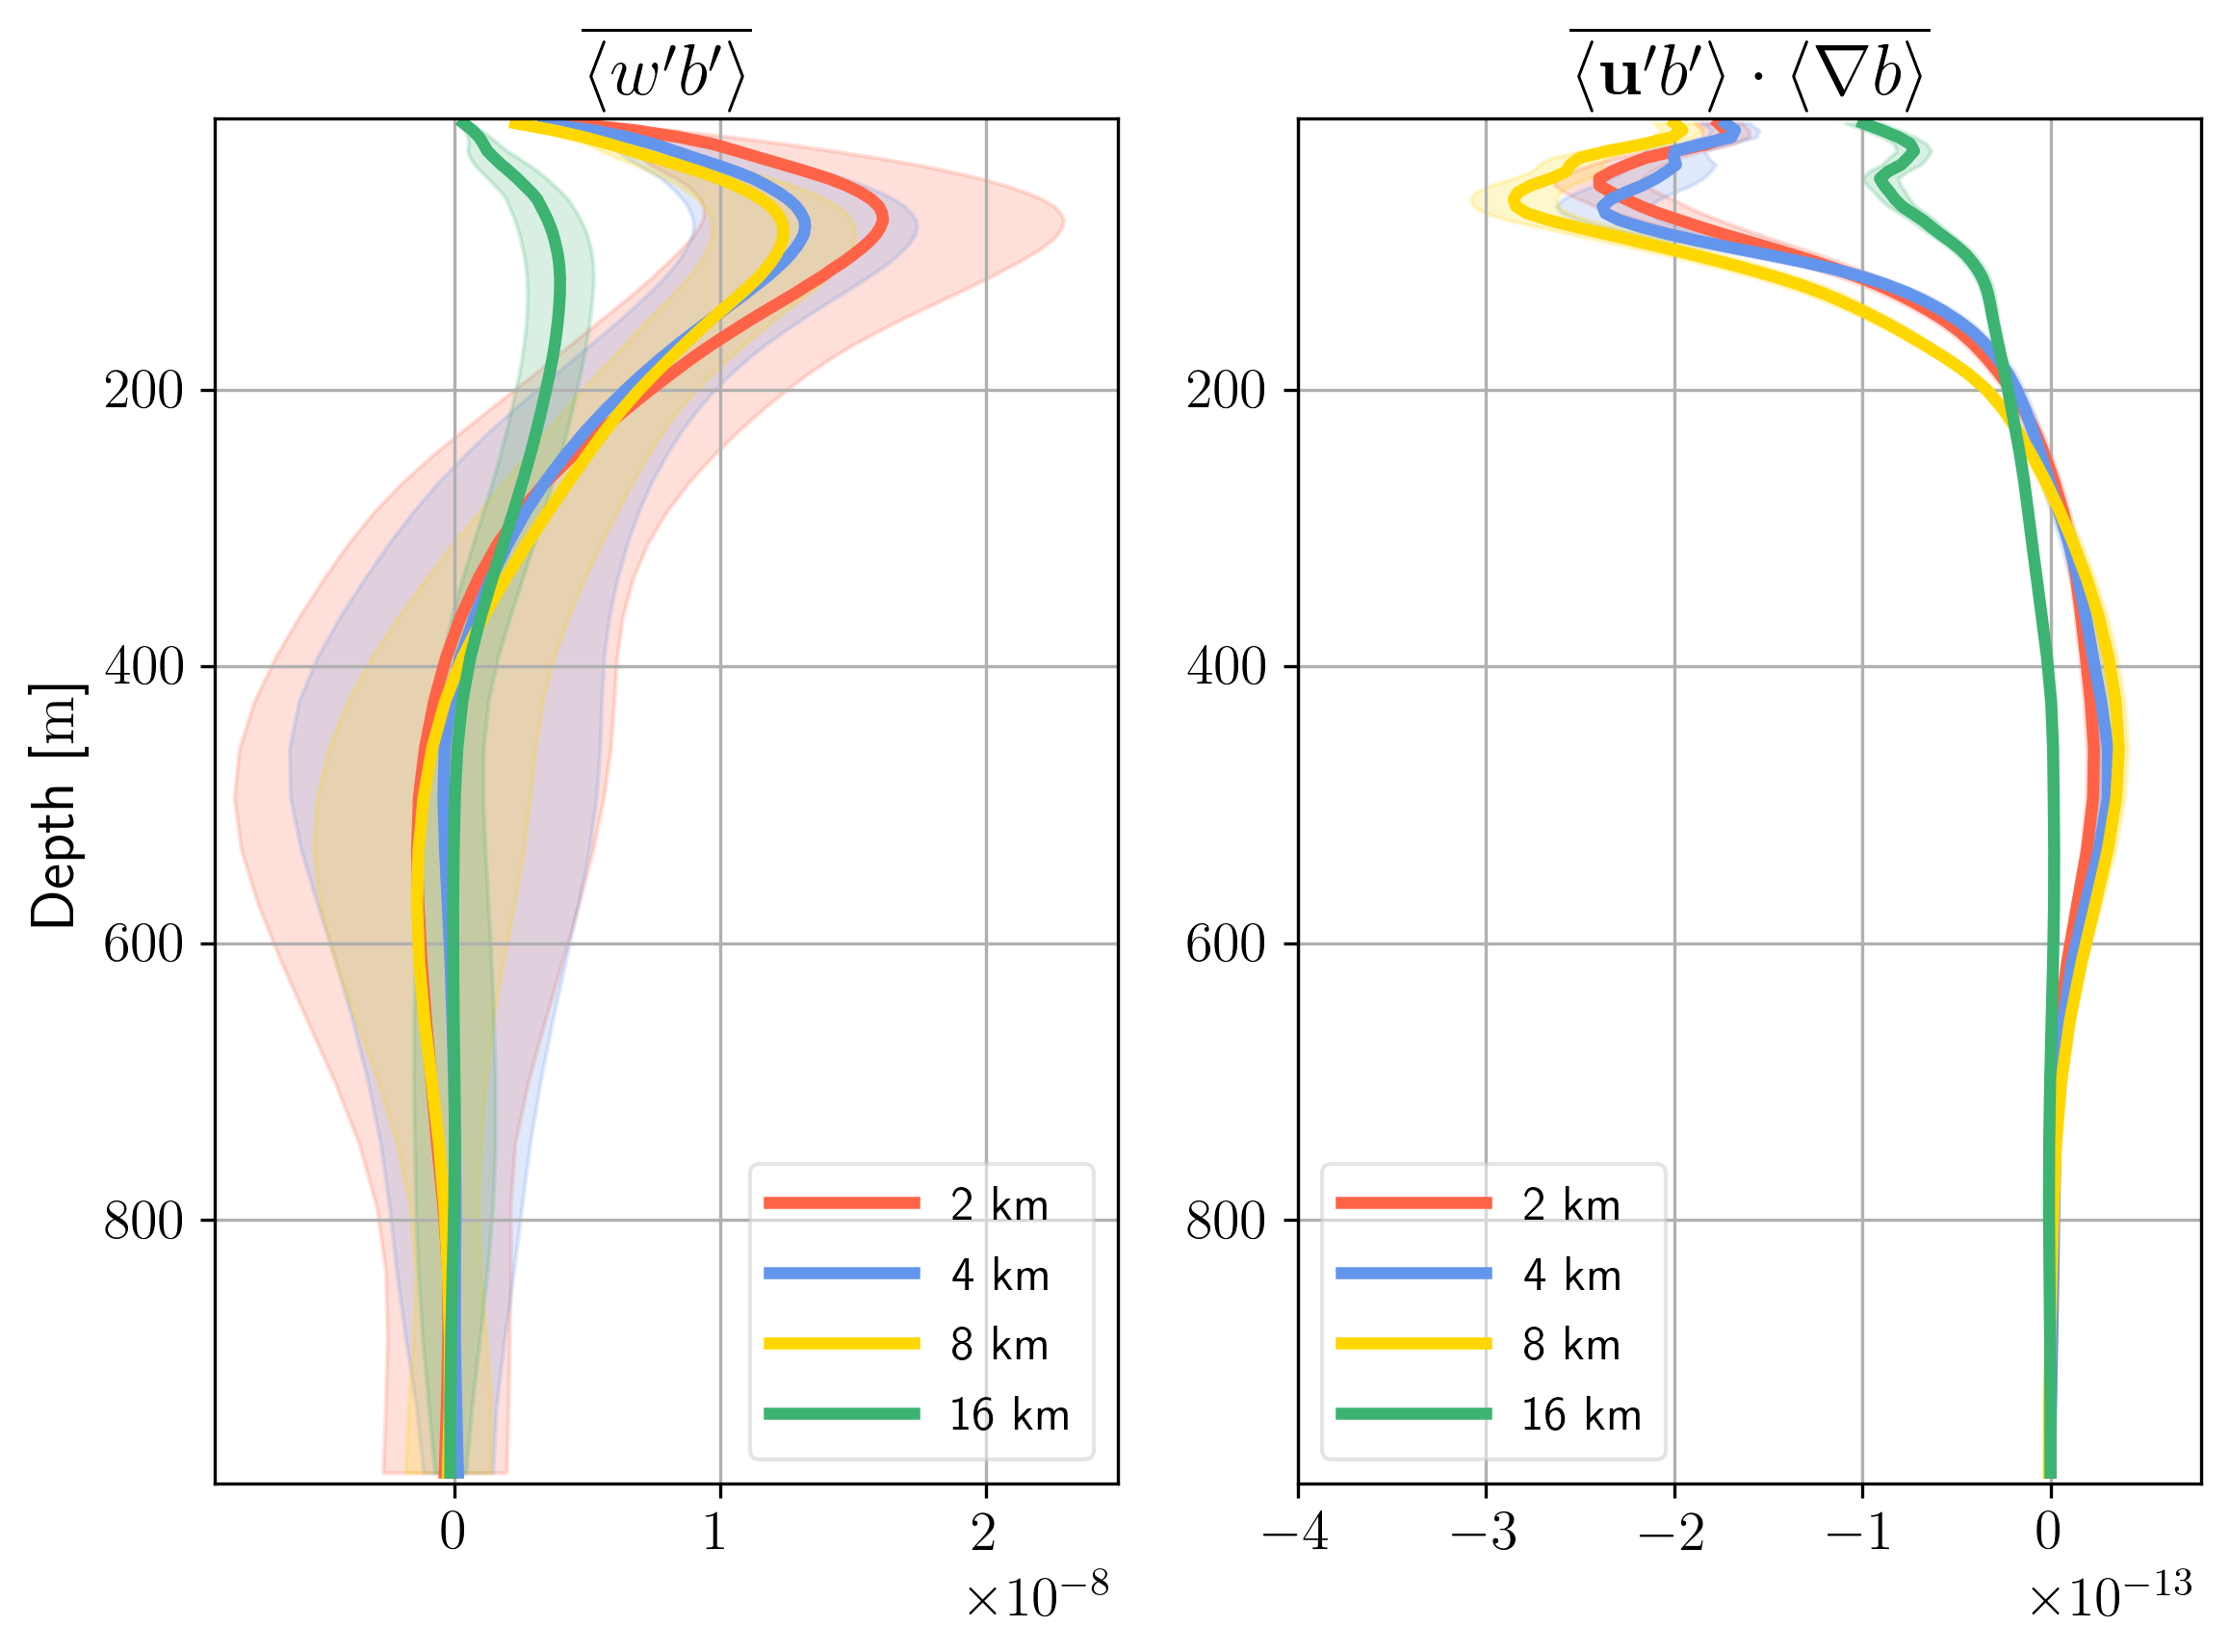

In [45]:
fig = plt.figure(figsize=(8,6), dpi=300)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:1])

for i,r in enumerate(res):
    
    ax1.plot(mean_std[r].wpbp_m, mean_std[r].Z, linewidth=3, color = colors[i],label=labels[r])
    ax1.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].wpbp_m+mean_std[r].wpbp_s/(N_deg[r]*Ndeg_s[r]), 
                      mean_std[r].wpbp_m-mean_std[r].wpbp_s/(N_deg[r]*Ndeg_s[r]), color = colors[i], alpha=0.2)
    ax1.set_ylim([-990,-4])
    ax1.set_yticks([-200,-400,-600,-800])
    ax1.set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    
    ax1.set_xlim([-0.9e-8,2.5e-8])
#     ax1.set_xlim([-1.9e-8,4.5e-8])
    ax1.set_ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
    plt.title(r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$', fontsize=18)
# ax1.set_xticks(np.array([0,3e-6,6e-6]))
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
ax2 = fig.add_subplot(gs[0, -1:])
for i,r in enumerate(res):
    
    ax2.plot(mean_std[r].Upbp_gradb_m, mean_std[r].Z, linewidth=3, color = colors[i],label=labels[r])
    ax2.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].Upbp_gradb_m - mean_std[r].Upbp_gradb_s/(N_deg[r]*Ndeg_s[r]), 
                      mean_std[r].Upbp_gradb_m + mean_std[r].Upbp_gradb_s/(N_deg[r]*Ndeg_s[r]), color = colors[i], alpha=0.2)
    ax2.set_ylim([-990,-4])
    ax2.set_yticks([-200,-400,-600,-800])
    ax2.set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    
    ax2.set_xlim([-4e-13,0.8e-13])
    ax2.set_ylabel('')
    plt.title(r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime}\rangle \cdot \langle \nabla b \rangle}$', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.tight_layout()

fig.savefig(figdir + 'wpbp_upbpgradb')
fig.savefig(figdir + 'wpbp_upbpgradb.pdf', dpi=200)

In [23]:
def plus_minus_sdlog(da):
    arr_m = np.log10(da.mean(dim=['time','Z']))
    arr_sd = (np.log10(da)).std(dim=['time','Z'])
    arr_l = arr_m - arr_sd
    arr_u = arr_m + arr_sd
    return (arr_m, arr_l, arr_u)

In [24]:
%%time

keiso_m100 = {}
keiso_l100 = {}
keiso_u100 = {}

for r in res:
    keiso_m100[r], keiso_l100[r], keiso_u100[r] = plus_minus_sdlog(iso_spec[r].keiso.sel(Z=slice(0,-100)))
    keiso_m100[r] = keiso_m100[r].load()
    keiso_l100[r] = keiso_l100[r].load()
    keiso_u100[r] = keiso_u100[r].load()

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/dask/array/reductions.py:386: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


CPU times: user 1min 26s, sys: 14.7 s, total: 1min 41s
Wall time: 1min 49s


In [30]:
for r in res:
    print(N_deg[r]*Ndeg_s[r])

170
170
170
150


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


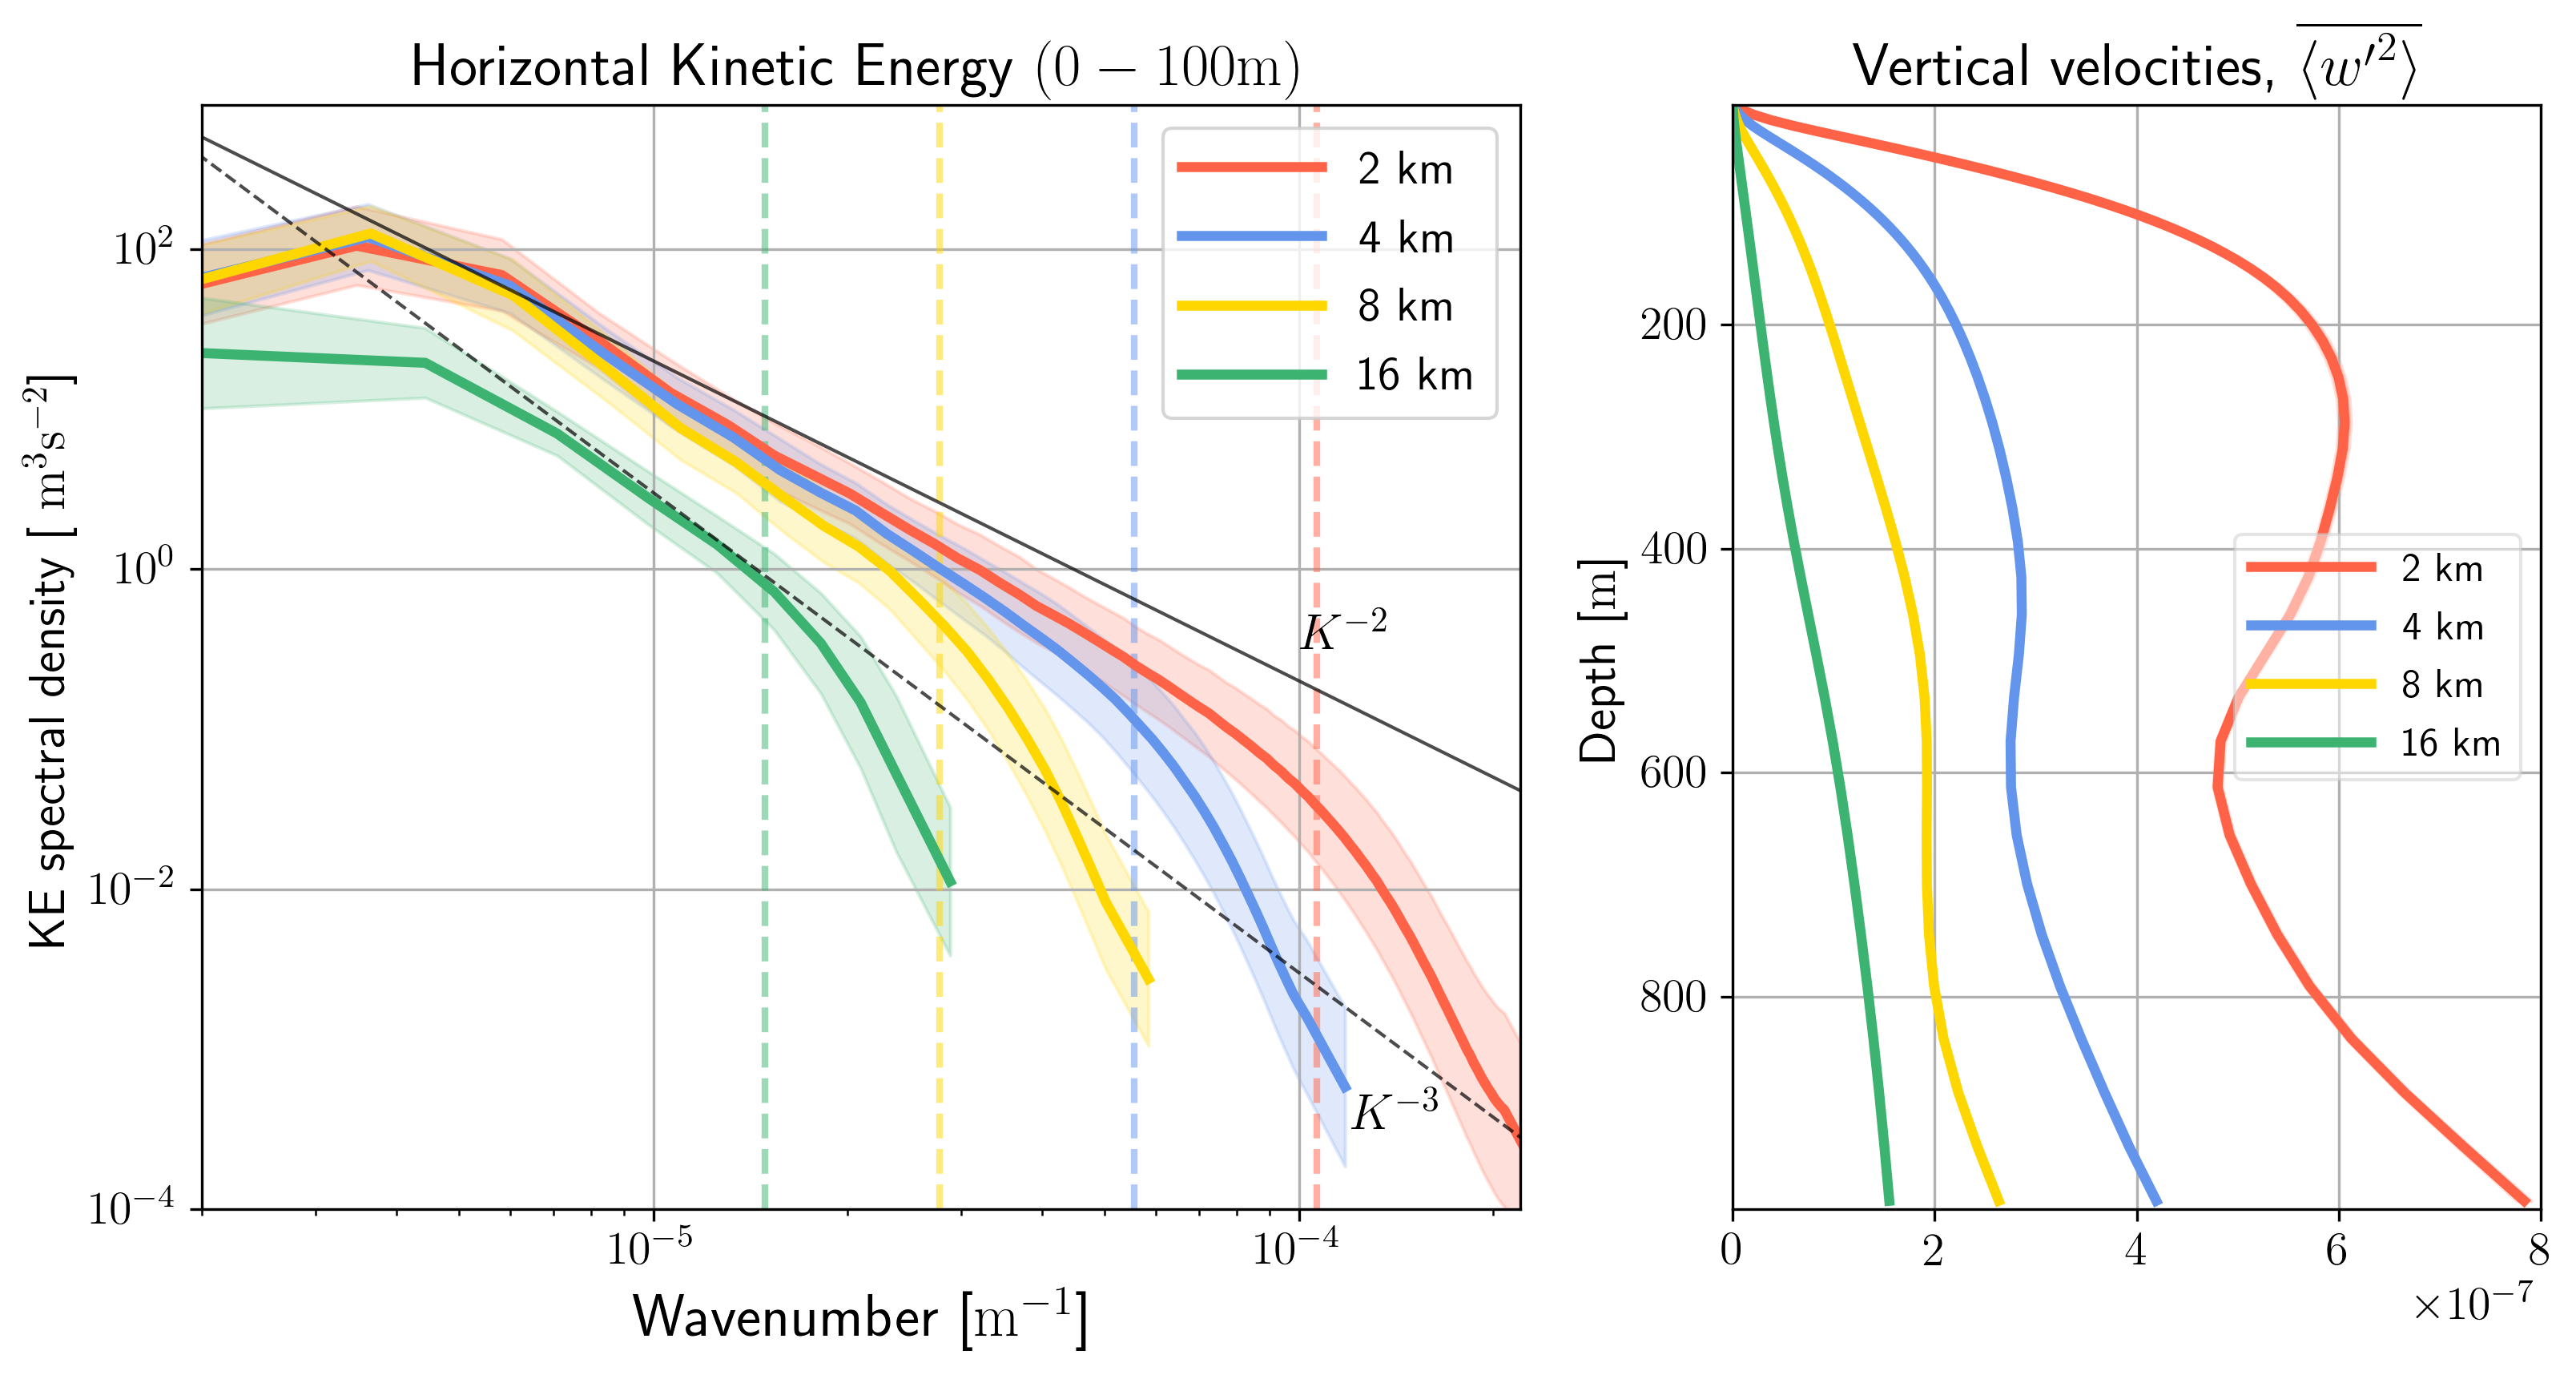

In [46]:
fig = plt.figure(figsize=(11,6), dpi=300)
gs = gridspec.GridSpec(ncols=5, nrows=1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:3])

ks = keiso_m100['2km'].freq_r
Es2 = 2e-9*keiso_m100['2km'].freq_r**-2
Es3 = 3e-15*keiso_m100['2km'].freq_r**-3

for i, r in enumerate(res):
    ax1.plot(keiso_m100[r].freq_r, keiso_m100[r], linewidth=3, color = colors[i], label = labels[r])
    
    ax1.fill_between(keiso_m100[r].freq_r,keiso_l100[r], keiso_u100[r], color = colors[i], alpha=0.2)
    
plt.legend(fontsize=14)

ax1.plot(ks,np.log10(Es2),'-', color='k',linewidth=1,alpha=.7)
ax1.plot(ks,np.log10(Es3),'--', color='k',linewidth=1,alpha=.7)
ax1.text(1e-4, -0.5, r'$K^{-2}$', fontsize=15)
ax1.text(1.2e-4, -3.5, r'$K^{-3}$', fontsize=15)
plt.title(r'Horizontal Kinetic Energy $\mathrm{(0-100m)}$', fontsize=18)
ax1.set_xscale('log', nonposx='mask')
ax1.set_ylim([-4,2.9])
ax1.set_xlim([2e-6,2.2e-4])

ax1.vlines((4.7*2e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color1)
ax1.vlines((4.5*4e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color2)
ax1.vlines((4.5*8e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color4)
ax1.vlines((4.2*16e3)**-1, -4,2.9, linewidth=2, linestyle='dashed', alpha=0.5, color=color3)
    
ax1.set_xlabel(r'Wavenumber [$\mathrm{m^{-1}}$]', fontsize=18)
ax1.set_ylabel(r'KE spectral density [ $\mathrm{m^{3}s^{-2}}$]', fontsize=15)

tck = np.array([-4,-2,0,2])
tcklbl =['$10^{-4}$', '$10^{-2}$','$10^{0}$','$10^{2}$', ]
ax1.set_yticks(tck)
ax1.set_yticklabels(tcklbl)
plt.grid()


ax2 = fig.add_subplot(gs[0, -2:])
for i,r in enumerate(res):
    
    ax2.plot(mean_std[r].wp2_m, mean_std[r].Z, linewidth=3, color = colors[i],label=labels[r])
    ax2.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].wp2_m - mean_std[r].wp2_s/(N_deg[r]*Ndeg_s[r]), 
                      mean_std[r].wp2_m + mean_std[r].wp2_s/(N_deg[r]*Ndeg_s[r]), color = colors[i], alpha=0.2)
#     ax2.fill_betweenx(mean_std[r].Z, 
#                       mean_std[r].wp2_m + mean_std[r].wp2_s/170, 
#                       mean_std[r].wp2_m - mean_std[r].wp2_s/170, color = colors[i], alpha=0.2)
    ax2.set_ylim([-990,-4])
    ax2.set_yticks([-200,-400,-600,-800])
    ax2.set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    ax2.set_xlim([0,8e-7])
    ax2.set_ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
    plt.title(r'Vertical velocities, $\overline{\langle {w^{\prime}}^2 \rangle}$ ', fontsize=18)
plt.legend(fontsize=12, loc=5, framealpha=0.5)
plt.grid()
plt.tight_layout()

fig.savefig(figdir + 'KEspec_wp2')
fig.savefig(figdir + 'KEspec_wp2.pdf', dpi=200)

In [18]:
%%time

wphbph = {}
for r in res:
    wphbph[r] = cross_spec[r].wphbph.mean(dim='time').load()

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 31.4 s, sys: 4.41 s, total: 35.9 s
Wall time: 1min 33s


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


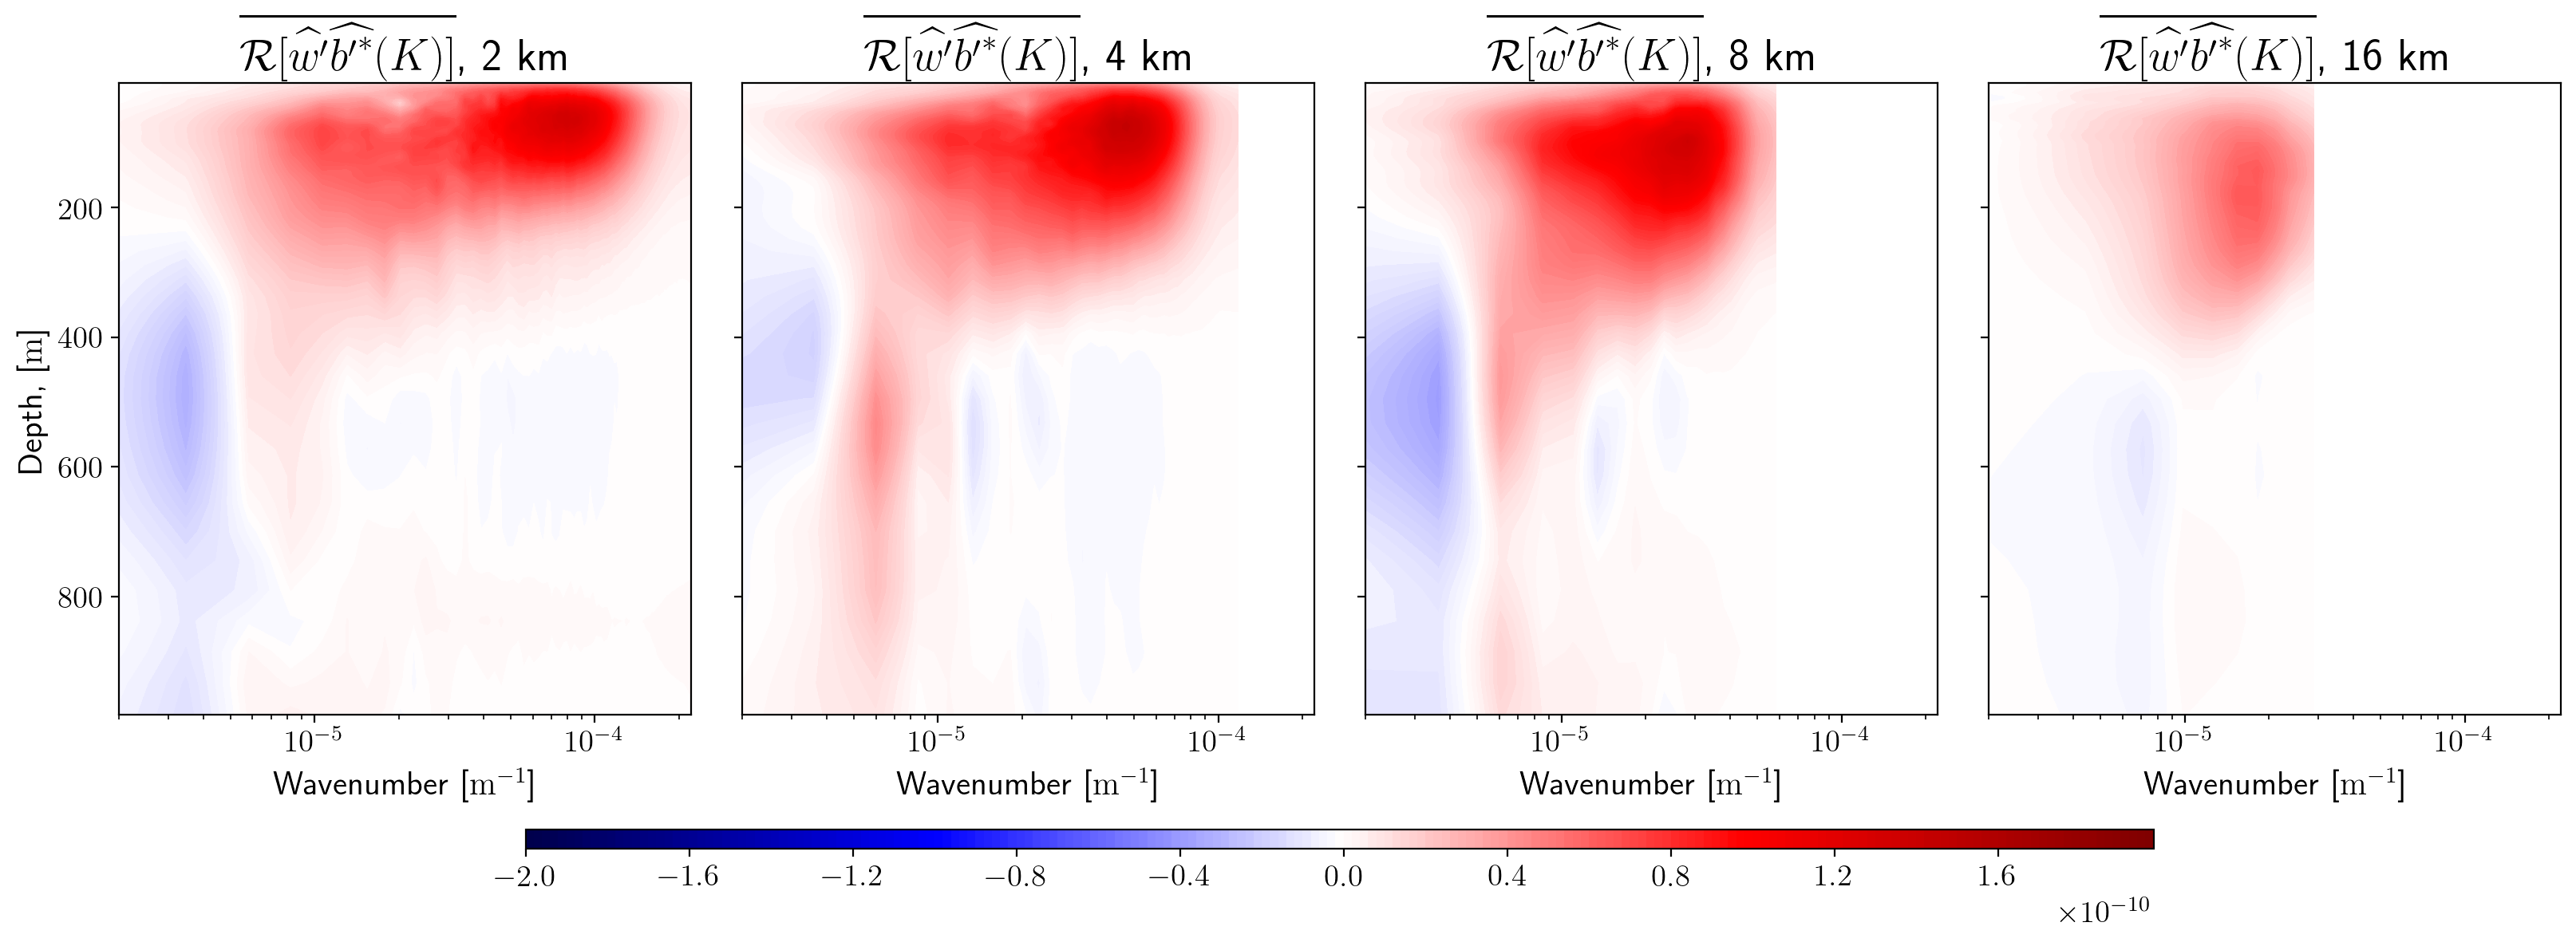

In [93]:
fig, axes = plt.subplots(ncols=4, figsize=(17,6), constrained_layout=True, dpi=200)
for i, r in enumerate(res):
    im0 = (wphbph[r]*wphbph[r].freq_r)[:,1:].plot.contourf(ax = axes[i], cmap='seismic', levels = np.arange(-2,2,2e-2)*1e-10, add_labels=False, add_colorbar=False)
    axes[i].set_xscale('log')
    axes[i].set_xlim([2e-6,2.2e-4])
    axes[i].set_xlabel(r'Wavenumber [$\mathrm{m^{-1}}$]', fontsize=15)
    if (r=='2km'):
        axes[i].set_ylabel(r'Depth, [$\mathrm{m}$]', fontsize=15)
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    else:
        axes[i].set_ylabel('')
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([])
    axes[i].set_title(r'$\overline{\mathcal{R}[\widehat{w^{\prime}} \widehat{{b^{\prime}}^*} (K)]}$, ' + labels[r])

fig.subplots_adjust(bottom=0.22, top= 0.88, left=0.05, right=0.95, wspace=0.09, hspace=0.35)

cax = plt.axes([0.2, 0.08, 0.6, 0.02])

cbar = fig.colorbar(im0, cax = cax, orientation='horizontal', extend='both')#, ticks = [-2,-1.5, 1, 0.5, 1, 1.5, 2])
#cbar.ax.set_xticklabels([r'])

fig.savefig(figdir+'wpbp_spectra')
fig.savefig(figdir+'wpbp_spectra.pdf', dpi=200)

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(primitive, **cbar_kwargs)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(primitive, **cbar_kwargs)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be re

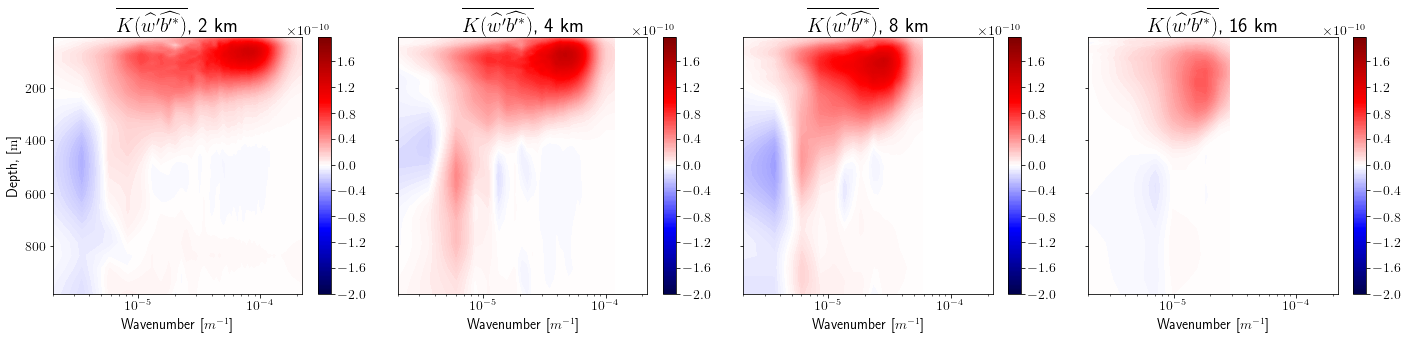

In [94]:
plt.figure(figsize=(20,5))

for i, r in enumerate(res):
    plt.subplot(1,4,i+1)
    (wphbph[r]*wphbph[r].freq_r)[:,1:].plot.contourf(cmap='seismic', levels = np.arange(-2,2,2e-2)*1e-10, add_labels=False)
    plt.xscale('log')
    plt.xlim([2e-6,2.2e-4])
    plt.xlabel(r'Wavenumber [$m^{-1}$]', fontsize=14)
    if (r=='2km'):
        plt.ylabel(r'Depth, [$\mathrm{m}$]', fontsize=14)
        plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
    else:
        plt.ylabel('')
        plt.yticks([-200,-400,-600,-800], [])
    plt.title(r'$\overline{K (\widehat{w^{\prime}} \widehat{{b^{\prime}}^*})}$, ' + labels[r])
plt.tight_layout()